# Machine Learning HW2 Simulation Part (Logistic Regression Classifier from Scratch)
## Amirmahdi Ansaripour (810198358)

## Exercise 2

In this part, the practice of fitting curve to seperate points of two classes is discussed. We have two datasets to which the algorithm is going to be applied.

The first dataset contains two classes of points:
1) 200 points belonging to a circular sector with (1.5, 0) as its origin and 4 and 9 as its lower and upper radius.

2) 200 points belonging to a circular sector with (1.5, 0) as its origin and 0 and 6 as its lower and upper radius.

The second dataset has two classes:
1) 100 points coming from a guassian distribution with (1, 0) as mean and 1 as standard deviation.

2) 200 points belonging to a circular sector with (1.5, 0) as its origin and 2 and 6 as its lower and upper radius

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [4]:
def preprocess(X):
    std = np.std(np.asarray(X))
    mean = np.mean(np.asarray(X))
    X = [(X[i] - mean)/(std) for i in range(len(X))]
    return X

In [5]:
def plot_points_in_sector(r1, r2, centerX, centerY, num_of_points):
    X = [0] * num_of_points
    Y = [0] * num_of_points
    random.seed(10)
    for i in range(num_of_points):
        randAngle = random.random() * 359
        randRadius = r1 + (random.random() * (r2 - r1))
        X[i] = centerX + (randRadius * math.cos(randAngle))
        Y[i] = centerY + (randRadius * math.sin(randAngle))
    return X, Y 

X_a, Y_a = plot_points_in_sector(r1 = 4, r2 = 9, centerX = 1.5, centerY = 0, num_of_points = 200)
X_b, Y_b = plot_points_in_sector(r1 = 0, r2 = 6, centerX = 1.5, centerY = 0, num_of_points = 200)

## Preprocessing
In order to make sure that both x and y features are treated equally in the curve fitting model, samples are standardized. 

Moreover, since a simple line does not seperate the classes properly, we should apply a phi-transform which converts the dataset with 2 dimensions to another dataset with more dimensions. The way phi-transform works is:

$$ {\vec{X} = [x_{1},\space x_{2}]^T}$$

$$ {\phi(\vec{X}) = [x_{1},\space x_{2},\space x_{1}^2,\space x_{1}x_{2},\space x_{2}^2,\space x_{1}^3,\space x_{1}^2x_{2},\space ...,\space x_{2}^7]^T} $$

$$ f: R^2 \rightarrow R^{35} $$

## Employing logistic regression on the first dataset

In [6]:
first_feature = preprocess(X_a + X_b)
second_feature = preprocess(Y_a + Y_b)

X = [first_feature, second_feature]
Y = []
for i in range(0, 200):
    Y.append(0)
for j in range(0, 200):
    Y.append(1)

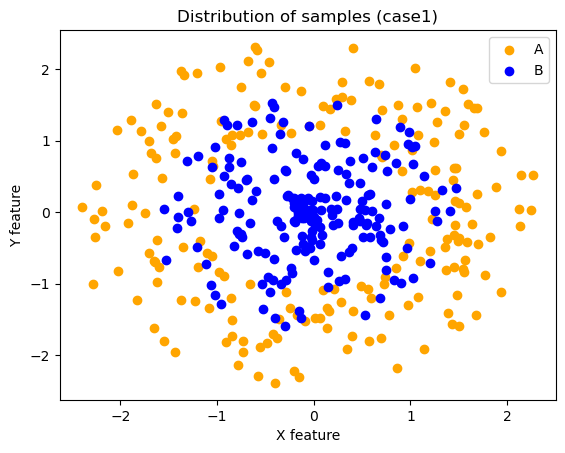

In [7]:
A = plt.scatter(X[0][0:200], X[1][0:200], color = 'orange')
B = plt.scatter(X[0][199:400], X[1][199:400], color = 'blue')
plt.xlabel("X feature")
plt.ylabel("Y feature")
plt.title("Distribution of samples (case1)")
plt.legend((A, B), ("A", "B"))
plt.show()

In [8]:
def fit_transform(X, degree):
    if isinstance(X[0], list) == False:
        new_features = [1]
        for j in range(1, degree + 1):
            for k in range(j+1):
                new_features.append(pow(X[0], j-k)*pow(X[1], k))
    else:
        new_features = [[0]] * len(X[0])
        for i in range(len(X[0])):
            new_features[i] = [1]
            for j in range(1, degree + 1):
                for k in range(j+1):
                    new_features[i].append(pow(X[0][i], j-k)*pow(X[1][i], k))
    return np.asarray(new_features)    

class LogisticRegression():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.w = []
    
    def sigmoid(self):
        res = np.asarray([0] * len(self.X)) # n x 1 && res = xT . w
        res = self.w@self.X.T
        final = []
#         print(res.shape)
        try:
            final = (1/(1 + np.exp(-res)))
        except OverflowError:
            print("Overflow: ", res[i]) # solved by preprocessing normalization
        final = np.asarray(final)
        return final

    def tuneweight(self, epoch_num, learning_rate, l2 = 0):
        self.X = np.asarray(self.X)
        self.Y = np.asarray(self.Y)
        self.w = np.asarray([0]*len(self.X[0])) # 1 x d
#         print(self.w)
#         print("X: ", self.X.shape)
#         print("Y: ", self.Y.shape)
#         print("w: ", self.w.shape)
        for occur in range(epoch_num):
            y_pred = self.sigmoid()
            diff = (y_pred - self.Y)
            dw = self.X.T@diff + (self.w*l2)
            
            self.w = self.w - dw*learning_rate
    
    def test(self, threshold = 0.5):
        y_pred = self.sigmoid()
        classpred = []
        for i in range(len(y_pred)):
            if y_pred[i] > threshold:
                classpred.append(1)
            else:
                classpred.append(0)
        return np.asarray(classpred)
    
    def get_optimal_weight(self):
        return self.w

In [9]:
def get_accuracy(Y, y_pred):
    correct = 0
    for i in range(len(Y)):
        if Y[i] == y_pred[i]:
             correct += 1
    accuracy = correct/len(Y)
    accuracy = round(accuracy, 3)
    return accuracy


In [10]:
def draw_boundry(first_feature, second_feature, degree, weight, message, f_X, f_Y, s_X, s_Y):
    newX = np.linspace(min(first_feature), max(first_feature), num_of_points_in_boundry)
    newY = np.linspace(min(second_feature), max(second_feature), num_of_points_in_boundry)
    PHI = np.zeros((num_of_points_in_boundry, num_of_points_in_boundry))
    for i in range(len(newX)):
        for j in range(len(newY)):
            PHI[i,j] = fit_transform([newX[i], newY[j]], degree).T@weight

    plt.contour(newX, newY, PHI, 0, colors = 'red')
    A = plt.scatter(f_X, f_Y, color = 'orange')
    B = plt.scatter(s_X, s_Y, color = 'blue')
    plt.xlabel("X feature")
    plt.ylabel("Y feature")
    plt.title(message)
    plt.legend((A, B), ("A", "B"))
    plt.show()

In [11]:
num_of_points_in_boundry = 100

### Effect of curve degree (complexity) on accuracy

Obviously, as the degree of the boundary increases, it is more possible that the model will overfit.

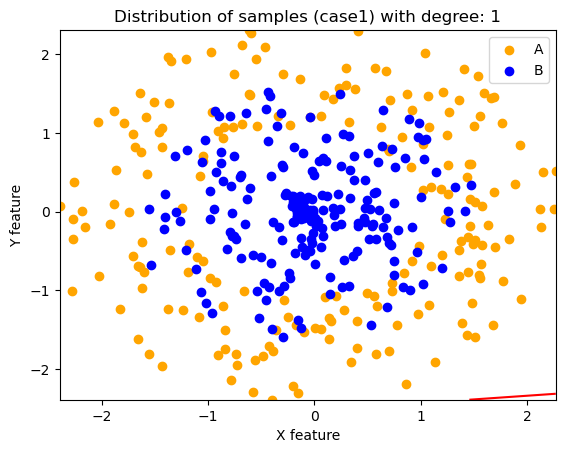

Accuracy of model: 0.5 



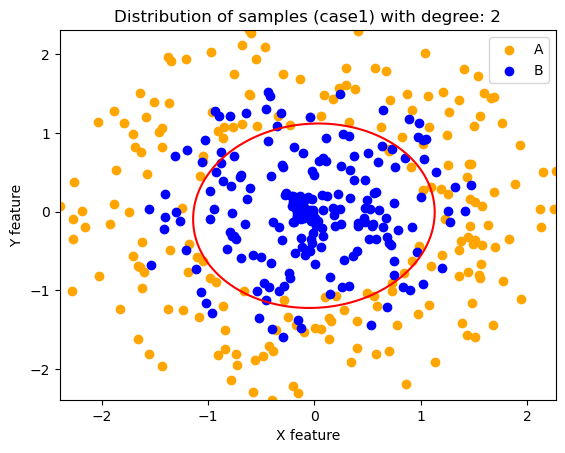

Accuracy of model: 0.848 



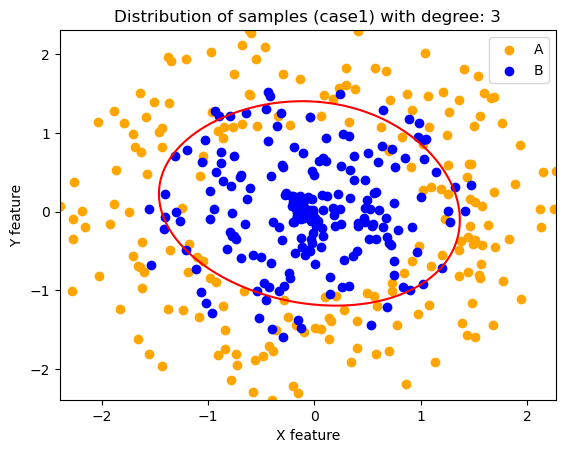

Accuracy of model: 0.807 



C:\Users\amirmahdi\AppData\Local\Temp\ipykernel_17932\2118638431.py:28: RuntimeWarning: overflow encountered in exp
  final = (1/(1 + np.exp(-res)))


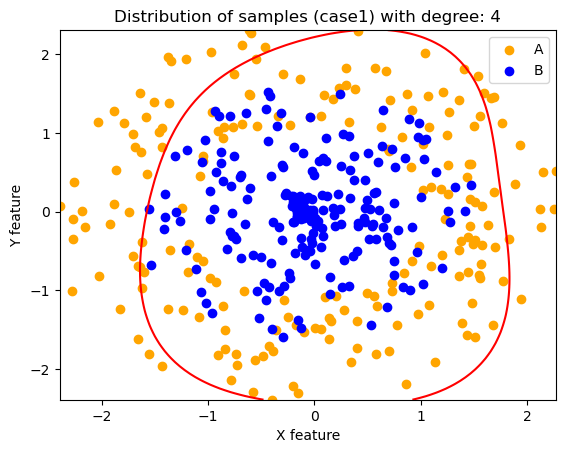

Accuracy of model: 0.625 



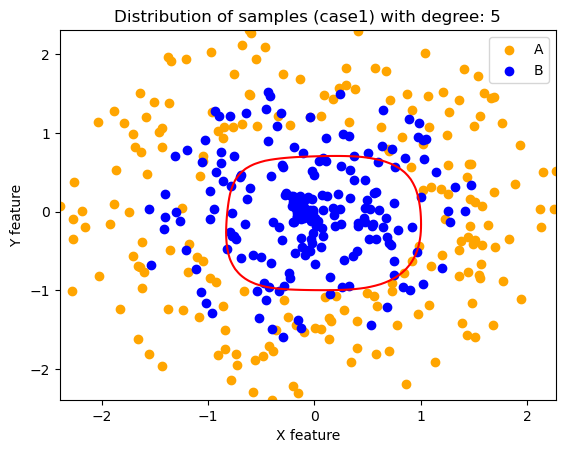

Accuracy of model: 0.805 



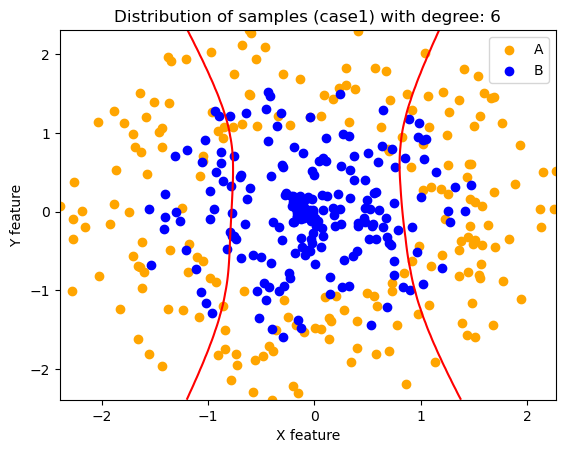

Accuracy of model: 0.685 



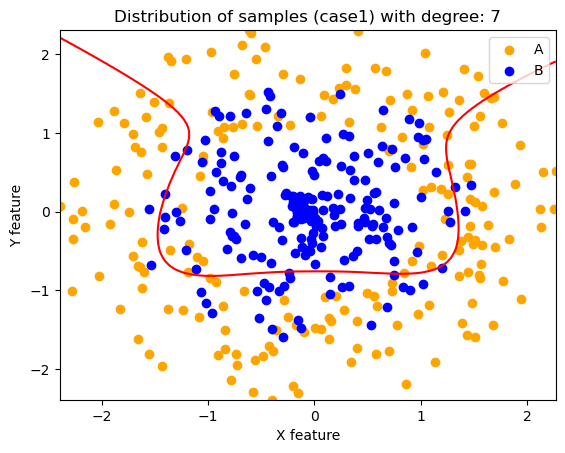

Accuracy of model: 0.698 



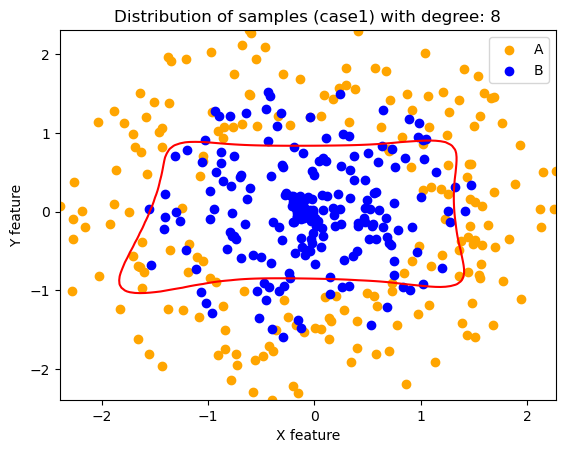

Accuracy of model: 0.797 



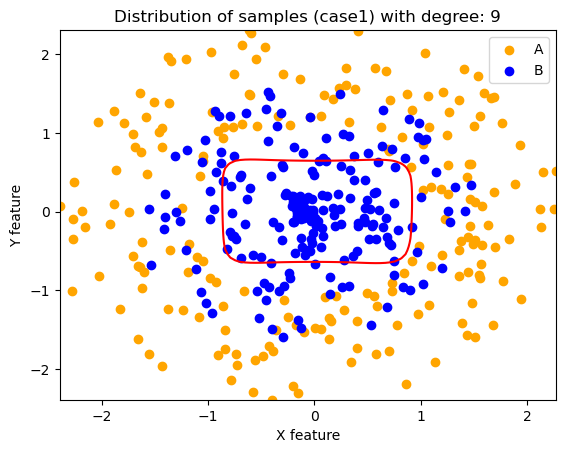

Accuracy of model: 0.76 



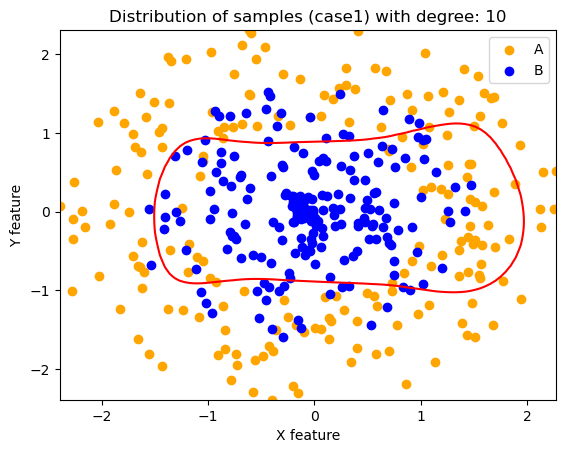

Accuracy of model: 0.777 



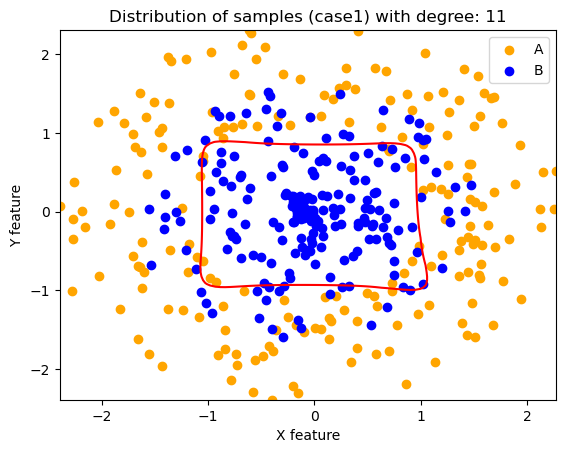

Accuracy of model: 0.83 



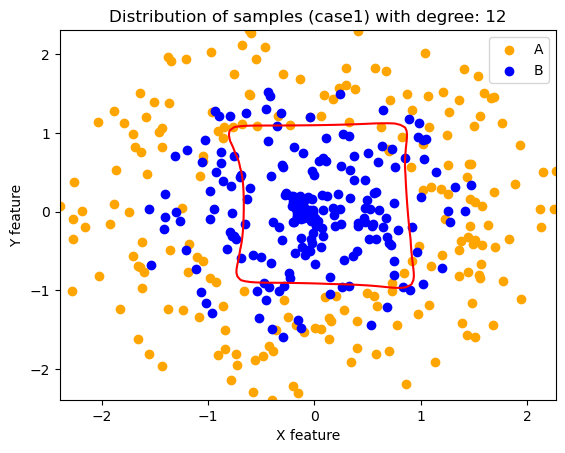

Accuracy of model: 0.807 



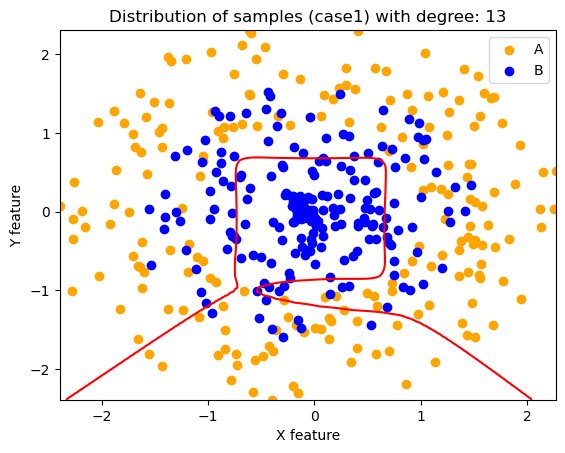

Accuracy of model: 0.708 



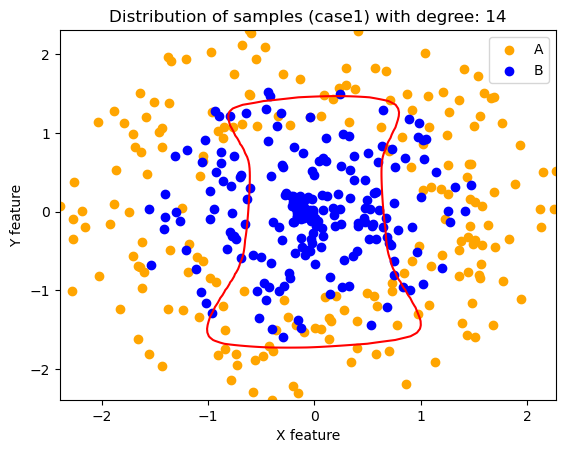

Accuracy of model: 0.777 



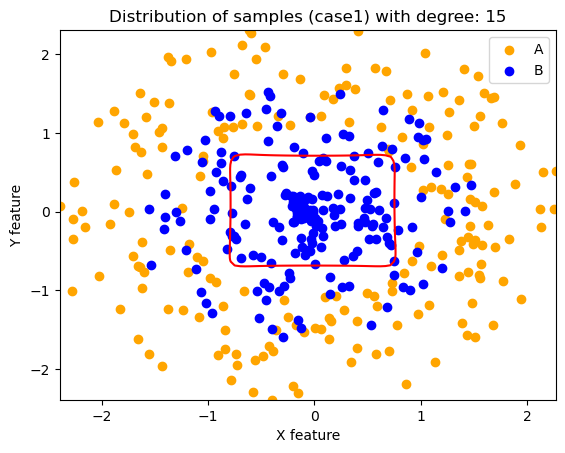

Accuracy of model: 0.762 



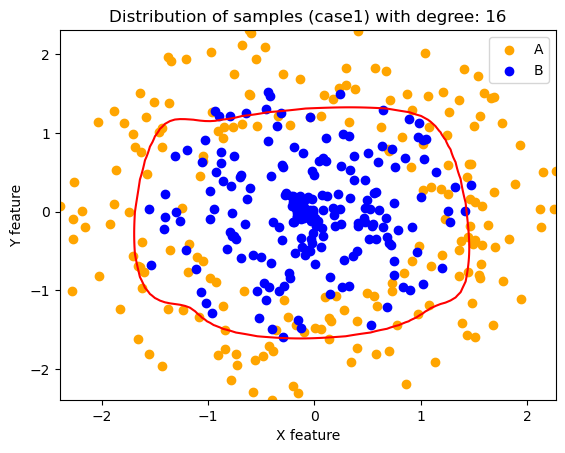

Accuracy of model: 0.807 



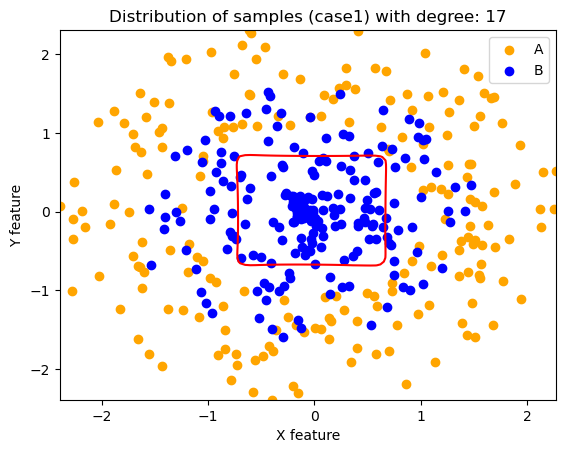

Accuracy of model: 0.752 



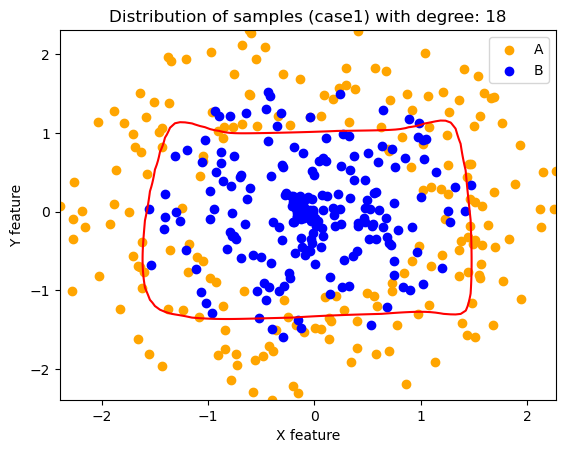

Accuracy of model: 0.795 



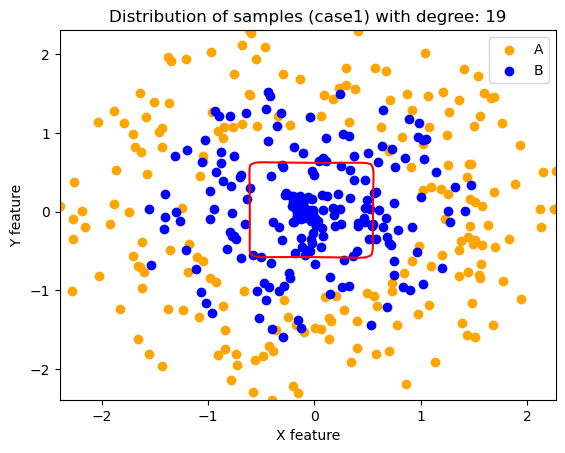

Accuracy of model: 0.71 



In [12]:
accuracy_list = []
for degree in range(1, 20):
    X_poly = fit_transform(X, degree)
    X_poly = np.asarray(X_poly)
    model = LogisticRegression(X_poly, Y)
    model.tuneweight(epoch_num = 100, learning_rate = 0.1, l2 = 0.4)
    y_pred = model.test()
    weight = model.get_optimal_weight()
    draw_boundry(first_feature, second_feature, degree, weight, 
                 "Distribution of samples (case1) with degree: " + str(degree), X[0][0:200], X[1][0:200], X[0][199:400], X[1][199:400])
    
    
#     A = plt.scatter(X[0][0:200], X[1][0:200], color = 'orange')
#     B = plt.scatter(X[0][199:400], X[1][199:400], color = 'blue')
    
    accuracy = get_accuracy(Y, y_pred)
    print("Accuracy of model:", accuracy, '\n')
    accuracy_list.append(accuracy)
    

In [13]:
degree_optimal = accuracy_list.index(max(accuracy_list)) + 1
print("The most accurate degree for fitting regression is: ", degree_optimal)

The most accurate degree for fitting regression is:  2


### Effect of L2 reguralization term on accuracy
Generally, we want to predict the weights (${\vec{w}}$) of a classifier such that :

$$\hat{\vec{y}} = \vec{w}^T \phi{(\vec{x})}$$
$$\vec{w}^{\ast} = \underset{\vec{w}}{\operatorname{argmin}} \space ( J(\vec{w}) + \lambda ||\vec{w}||^2)$$

Where $J(\vec{w})$ is the main cost function. In order to prohibit the classifier's weights from getting excessively large values (i.e., keeping the model simple), a regularization term has been added (with $\lambda$ as coefficient). Pay attention that the term mentioned above is called L2 regularization term because of its quadragic form. Other regularization terms are:

1) L0 term: $\space \space \space \space$ ${\lambda ||\vec{w}||^0}$ (Useful when number of non-zero weights should be limited)
2) L1 term: $\space \space \space \space$ ${\lambda ||\vec{w}||^1}$ (Useful when the abstract value of weights should not exceed significantly)

The point about choosing the correct value of $\lambda$ is : 
1) If $\lambda$ is set to a high value, $||\vec{w}||$ will be small, so the model will be simple.
2) If $\lambda$ is set to a low value, $||\vec{w}||$ will be large, so the model will probably overfit. 

Text(0.5, 1.0, 'Effect of L2 regularization term on accuracy')

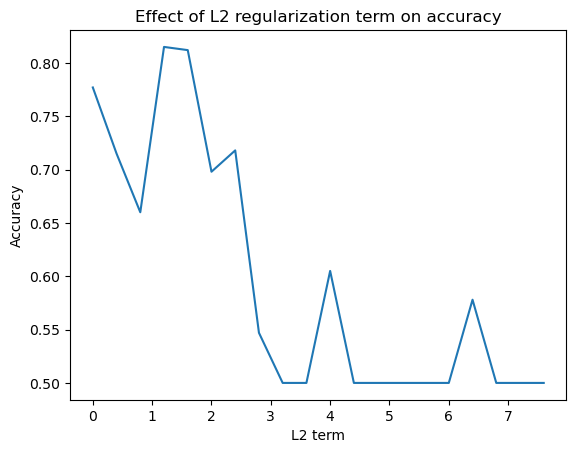

In [14]:
accuracy_list.clear()
L2_range = np.arange(0, 8, 0.4)
for L2 in L2_range:
    X_poly = fit_transform(X, 2)
    X_poly = np.asarray(X_poly)
    model = LogisticRegression(X_poly, Y)
    model.tuneweight(epoch_num = 50, learning_rate = 0.1, l2 = round(L2, 3))
    y_pred = model.test()
    weight = model.get_optimal_weight()
    accuracy = get_accuracy(Y, y_pred)
    accuracy_list.append(accuracy)

plt.plot(L2_range, accuracy_list)
plt.xlabel("L2 term")
plt.ylabel("Accuracy")
plt.title("Effect of L2 regularization term on accuracy")

### Model Analysis

1) As the graphs in the previous part indicate, the best curve which can be fitted in order to seperate the dataset has a degree of two. As the degree gets higher, the model becomes more complex, which adds to its variance (for example degrees 6, 7, 13, and 14).

2) It can be concluded that the best L2 term is near 1.50. As it gets higher, the model underfits because it is not allowed to be flexible. In other words, its weights are small because it has been punished by the large L2 coefficient. 

## Employing logistic regression on the second dataset

In [15]:
def make_dataset_based_on_stdev(x, y, k):
    random.seed(0)
    X_random = random.choices(np.arange(-100, 100, 0.2), k = k)
    Y_random = random.choices(np.arange(-100, 100, 0.2), k = k)
    meanX = np.mean(X_random)
    stdX = np.std(X_random)
    meanY = np.mean(Y_random)
    stdY = np.std(Y_random)
    X_random = [((X_random[i] - meanX) / stdX) + x for i in range(len(X_random))] ## mean of X should be 1
    Y_random = [((Y_random[i] - meanY) / stdY) + y for i in range(len(Y_random))]
    return X_random, Y_random
    

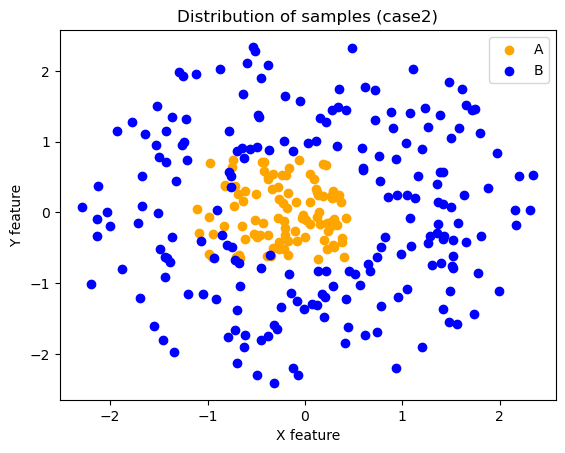

In [16]:
# del X_a, Y_a, X_b, Y_b, first_feature, second_feature ,A, B, accuracy_list
X_a, Y_a = make_dataset_based_on_stdev(1, 0, 100)
X_b, Y_b = plot_points_in_sector(r1 = 2, r2 = 6, centerX = 1.5, centerY = 0, num_of_points = 200)
first_feature = preprocess(X_a + X_b)
second_feature = preprocess(Y_a + Y_b)

X_n = [first_feature, second_feature]
Y_n = []
for i in range(0, 100):
    Y_n.append(0)
for j in range(0, 200):
    Y_n.append(1)

A = plt.scatter(X_n[0][0:100], X_n[1][0:100], color = 'orange')
B = plt.scatter(X_n[0][99:300], X_n[1][99:300], color = 'blue')
plt.xlabel("X feature")
plt.ylabel("Y feature")
plt.title("Distribution of samples (case2)")
plt.legend((A, B), ("A", "B"))
plt.show()

### Effect of curve degree (complexity) on accuracy

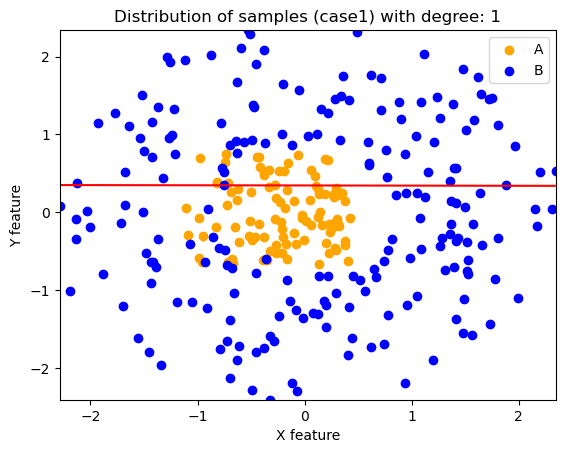

Accuracy of model: 0.373 



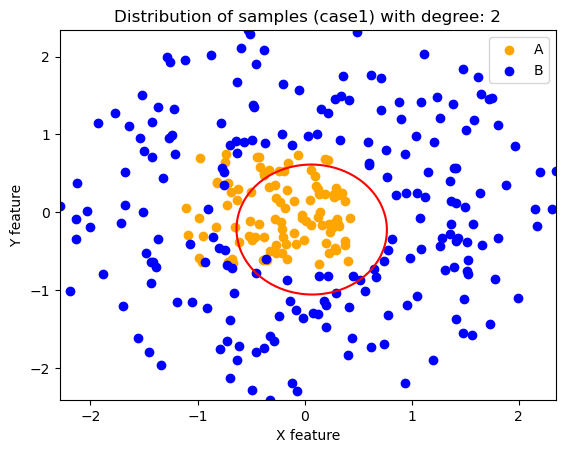

Accuracy of model: 0.927 



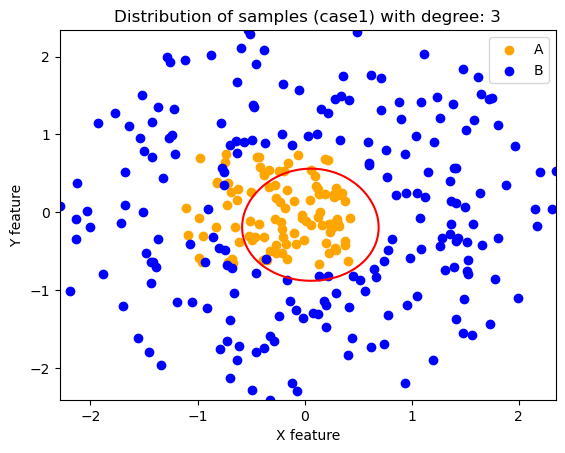

Accuracy of model: 0.92 



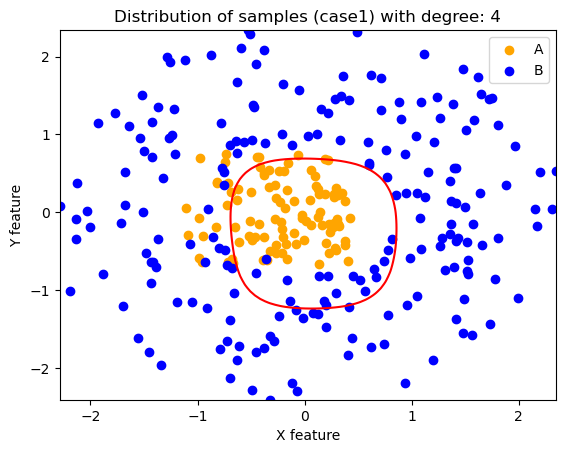

Accuracy of model: 0.953 



C:\Users\amirmahdi\AppData\Local\Temp\ipykernel_17932\2118638431.py:28: RuntimeWarning: overflow encountered in exp
  final = (1/(1 + np.exp(-res)))


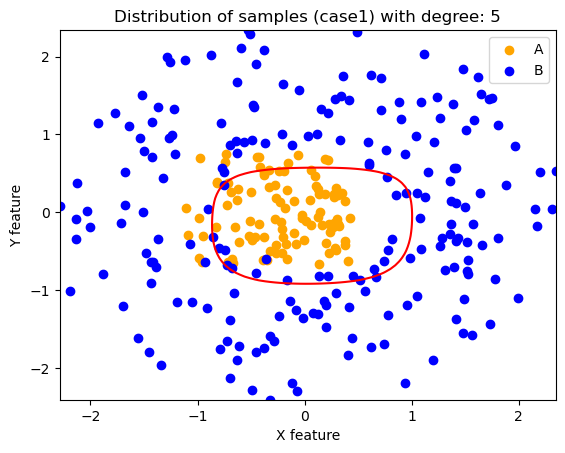

Accuracy of model: 0.92 



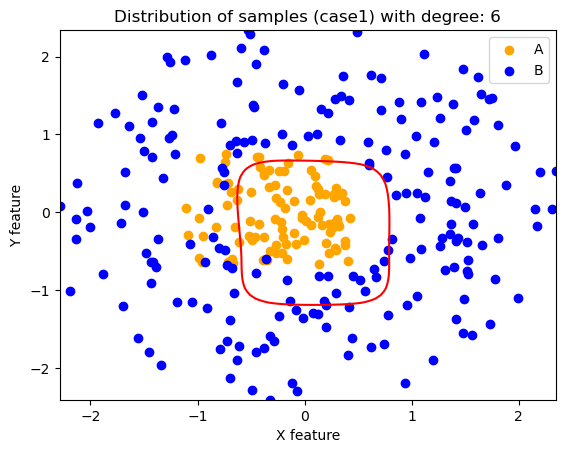

Accuracy of model: 0.95 



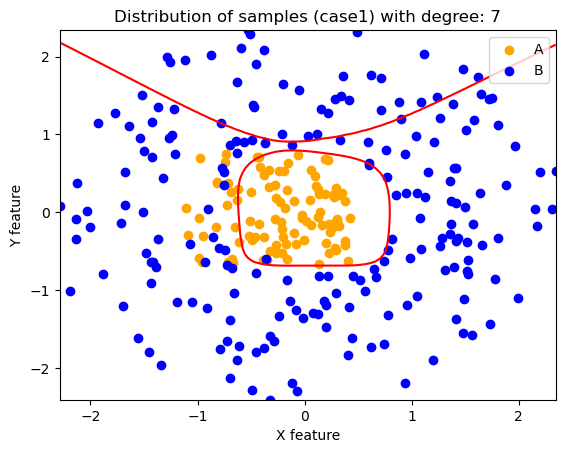

Accuracy of model: 0.767 



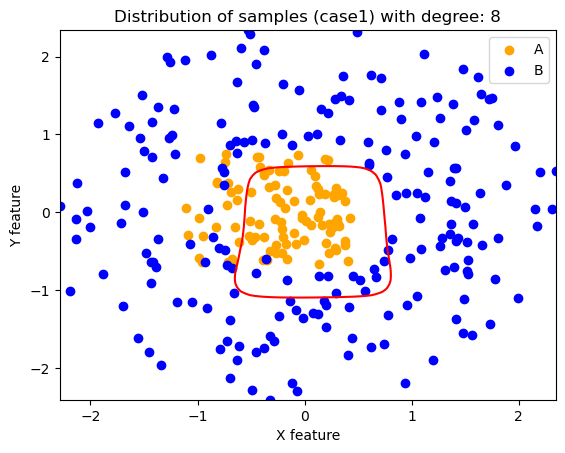

Accuracy of model: 0.94 



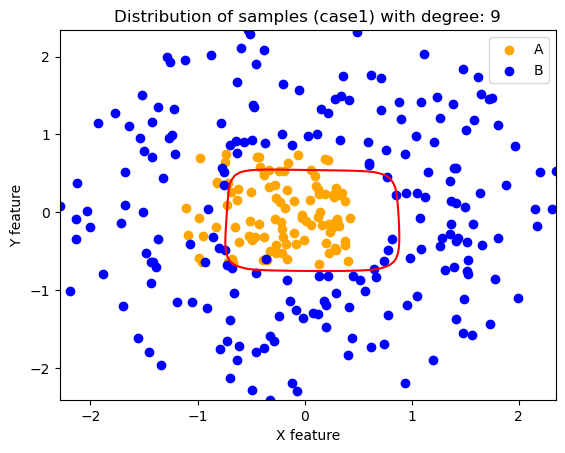

Accuracy of model: 0.937 



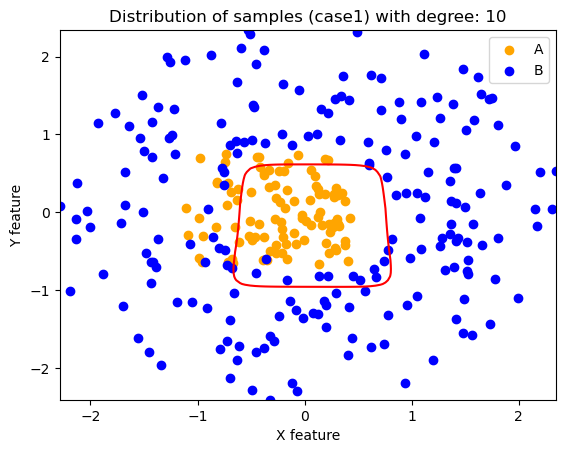

Accuracy of model: 0.943 



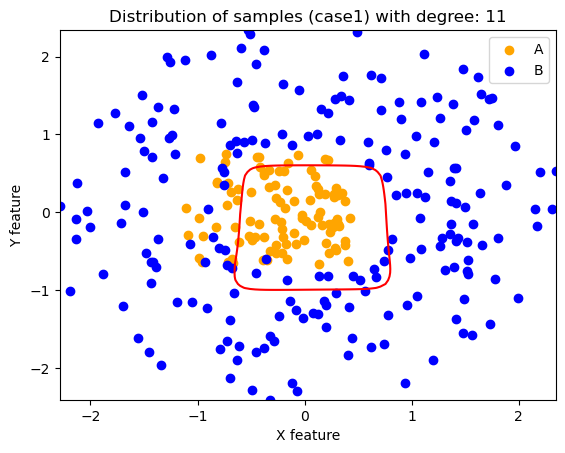

Accuracy of model: 0.94 



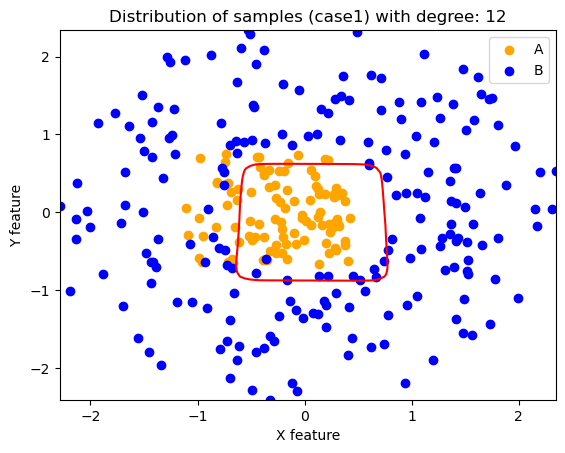

Accuracy of model: 0.933 



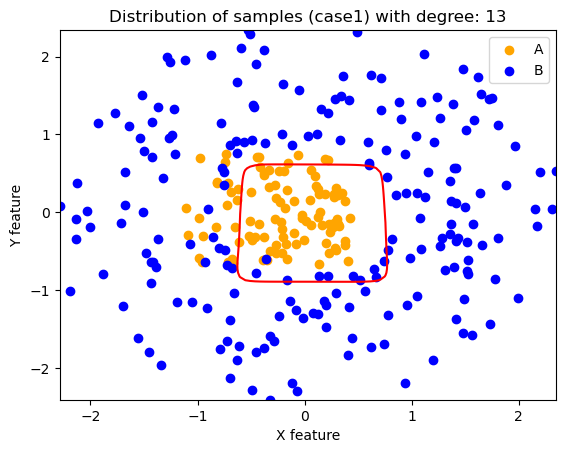

Accuracy of model: 0.933 



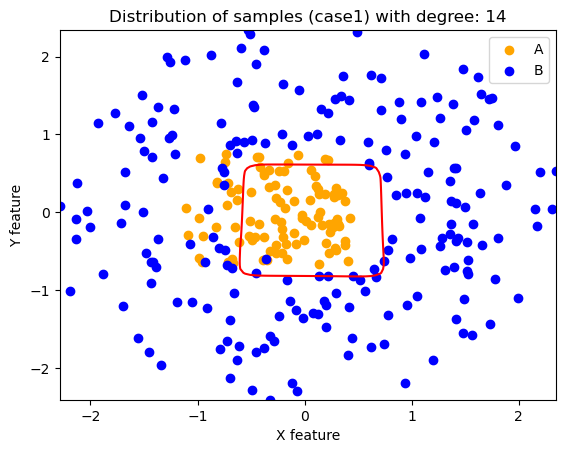

Accuracy of model: 0.937 



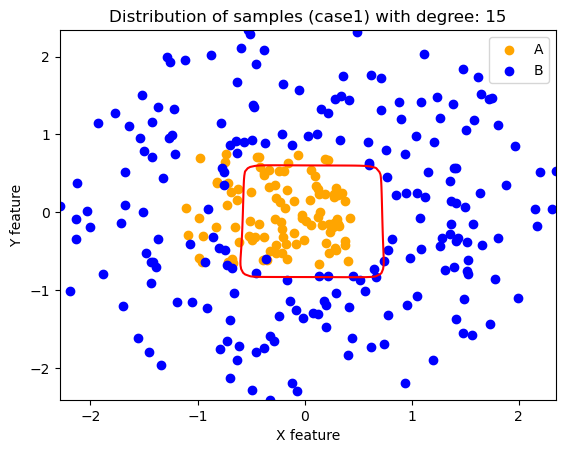

Accuracy of model: 0.933 



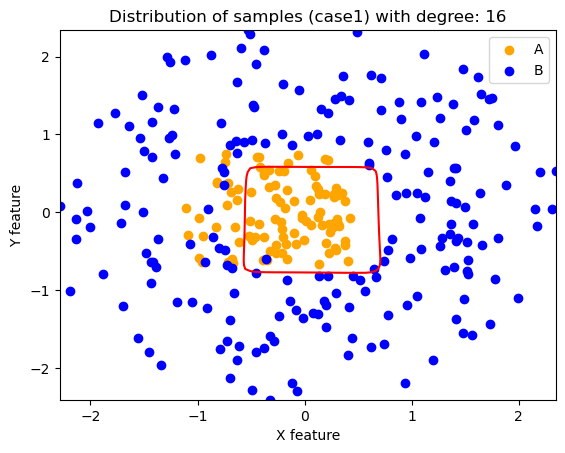

Accuracy of model: 0.92 



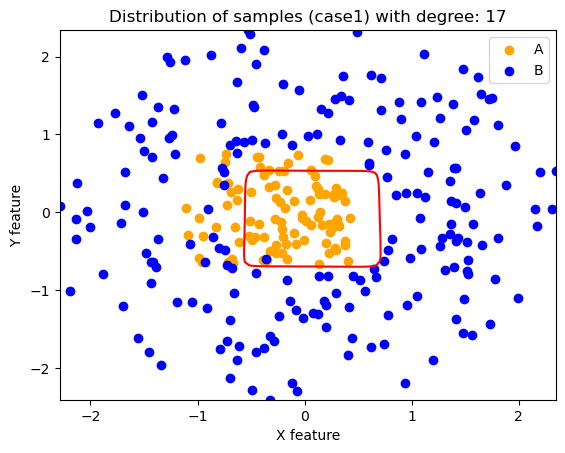

Accuracy of model: 0.913 



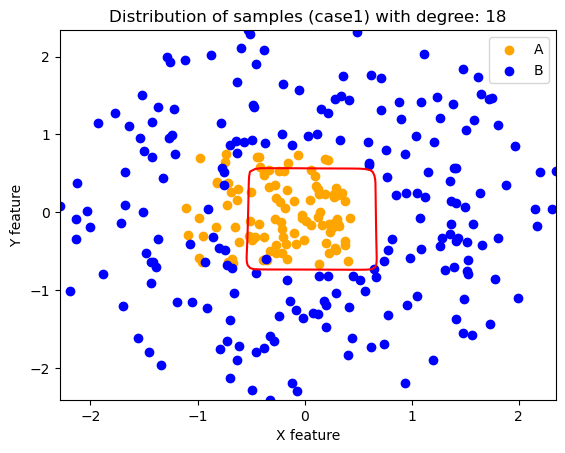

Accuracy of model: 0.913 



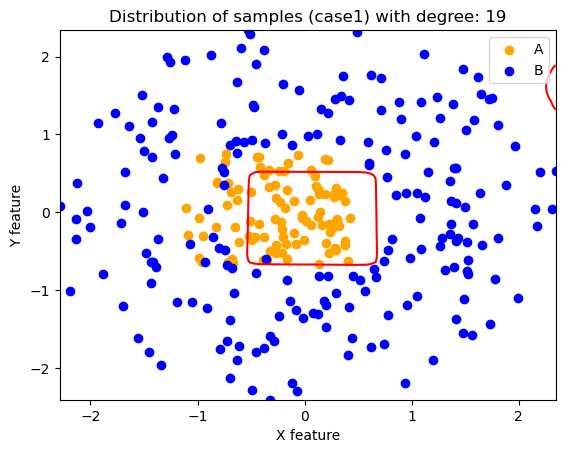

Accuracy of model: 0.9 



In [33]:
accuracy_list = []
for degree in range(1, 20):
    X_poly = fit_transform(X_n, degree)
    X_poly = np.asarray(X_poly)
    model = LogisticRegression(X_poly, Y_n)
    model.tuneweight(epoch_num = 50, learning_rate = 0.1, l2 = 0.4)
    y_pred = model.test()
    weight = model.get_optimal_weight()
    draw_boundry(first_feature, second_feature, degree, weight,
                 "Distribution of samples (case1) with degree: " + str(degree), X_n[0][0:100], X_n[1][0:100], X_n[0][99:300], X_n[1][99:300])
    accuracy = get_accuracy(Y_n, y_pred)
    print("Accuracy of model:", accuracy, '\n')
    accuracy_list.append(accuracy)


In [18]:
degree_optimal = accuracy_list.index(max(accuracy_list)) + 1
print("The most accurate degree for fitting regression is: ", degree_optimal)

The most accurate degree for fitting regression is:  4


### Effect of L2 reguralization term on accuracy

C:\Users\amirmahdi\AppData\Local\Temp\ipykernel_17932\2118638431.py:28: RuntimeWarning: overflow encountered in exp
  final = (1/(1 + np.exp(-res)))


Text(0.5, 1.0, 'Effect of L2 regularization term on accuracy')

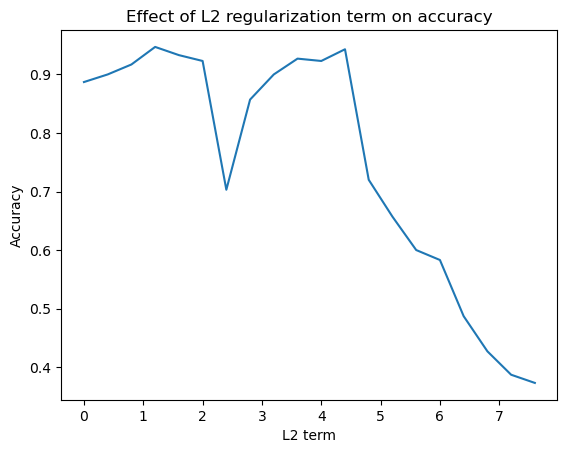

In [45]:
accuracy_list.clear()
L2_range = np.arange(0, 8, 0.4)
for L2 in L2_range:
    X_poly = fit_transform(X_n, 19)
    X_poly = np.asarray(X_poly)
    model = LogisticRegression(X_poly, Y_n)
    model.tuneweight(epoch_num = 50, learning_rate = 0.1, l2 = round(L2, 3))
    y_pred = model.test()
    weight = model.get_optimal_weight()
    accuracy = get_accuracy(Y_n, y_pred)
    accuracy_list.append(accuracy)

plt.plot(L2_range, accuracy_list)
plt.xlabel("L2 term")
plt.ylabel("Accuracy")
plt.title("Effect of L2 regularization term on accuracy")

### Model analysis

The expected trends also occurred for the second dataset. For low degrees (simple models) the model is underfitted and has a high bias. As the complexity increases, we get better accuracies. But when the optimality level is passed, the model overfits, and its accuracy decreases after passing a peak.  

Moreover, we can prevent a model from getting too complicated by adding a L2 regularization term. The term punishes the model whenever its weights are exterme. As a result, by increasing the value of $\lambda$, the model gets simpler and its weights remain negligible. However, as the graph drawn above indicates, low $\lambda$ values cause the model to undefit (high biass) and become very simple.

